     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 22.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446711 sha256=37cf65ca4e6ff810752d3d1c1982575ef6355c719074a3f812dfcdd8b5a98474
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

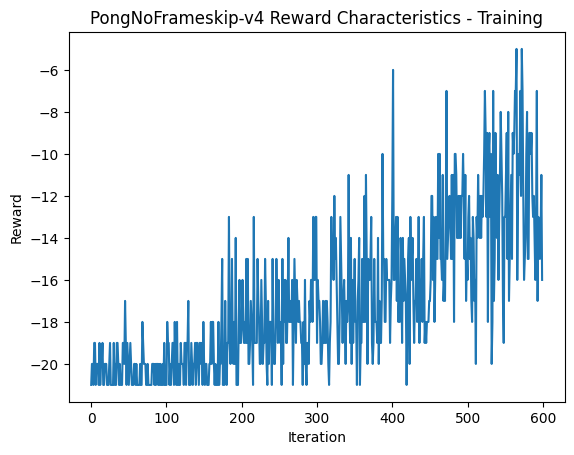

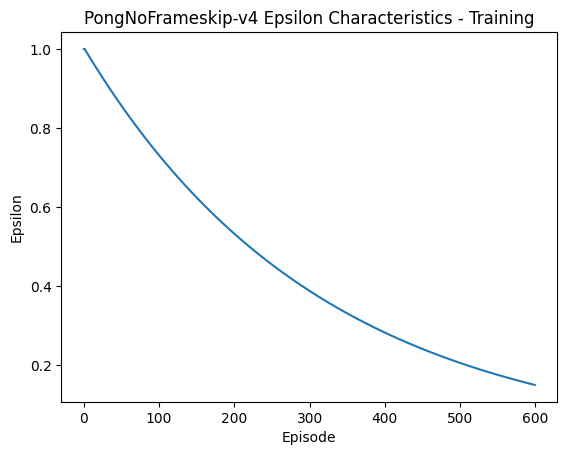

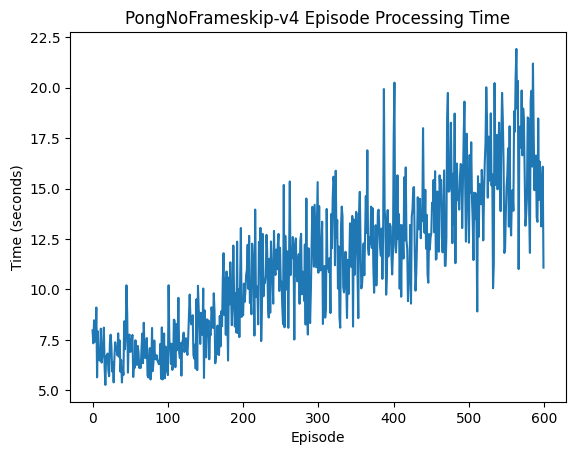

In [1]:
# Install dependencies in Colab
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]
!pip install torch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import ale_py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import time
import os

# Register
gym.register_envs(ale_py)

# DQN
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    BATCH_SIZE = 32
    EPSILON_START = 1
    EPSILON_CUTOFF = 0.1
    EPSILON_DECAY = 0.99684
    GAMMA = 0.99
    LR = 1e-4
    MEMORY_SIZE = 10000
    total_steps = 0

    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayBuffer(self.MEMORY_SIZE)
        self.steps_done = 0
        self.epsilon = self.EPSILON_START
        self.current_episode = 0

    def select_e_greedy_action(self, env, state):
        if random.random() < self.epsilon:
            return random.randint(0, env.action_space.n - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state).argmax(dim=1).item()

    def select_greedy_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return self.policy_net(state).argmax(dim=1).item()

    def decay_epsilon(self):
        self.total_steps += 1
        self.epsilon = max(self.EPSILON_CUTOFF, self.EPSILON_START * (self.EPSILON_DECAY ** self.current_episode))

    def step(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        batch = self.memory.sample(self.BATCH_SIZE)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).unsqueeze(1)
        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1, keepdim=True)[0].detach()
        target_q = rewards + (self.GAMMA * next_q * (1 - dones))

        loss = F.mse_loss(target_q, current_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Training Function
def train_q_values(env, env_name, target_update_interval=10, training_episodes=1000, agent_class=DQNAgent, checkpoint_path=None):
    agent = agent_class()
    rewards_per_episode = []
    epsilon_values = []
    episode_times = []
    start_episode = 0

    # Load checkpoint if provided
    drive_path = '/content/drive/MyDrive/dqn_pong_checkpoints/'  # Google Drive folder
    if checkpoint_path is not None:
        checkpoint = torch.load(os.path.join(drive_path, checkpoint_path))
        agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        agent.target_net.load_state_dict(checkpoint['policy_net_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent.total_steps = checkpoint['total_steps']
        agent.current_episode = checkpoint['current_episode']
        rewards_per_episode = checkpoint['rewards_per_episode']
        epsilon_values = checkpoint['epsilon_values']
        episode_times = checkpoint['episode_times']
        start_episode = checkpoint['current_episode'] + 1
        agent.epsilon = max(agent.EPSILON_CUTOFF, agent.EPSILON_START * (agent.EPSILON_DECAY ** agent.current_episode))
        print(f"Resumed training from episode {start_episode}")

    for episode in range(start_episode, training_episodes):
        agent.current_episode = episode
        start_time = time.time()
        obs, _ = env.reset()
        state = obs
        total_reward = 0
        done = False
        steps_taken = 0
        episode_transitions = []

        epsilon_values.append(agent.epsilon)

        while not done:
            action = agent.select_e_greedy_action(env, state)
            obs, reward, done, _, _ = env.step(action)
            next_state = np.array(obs, dtype=np.float32)
            episode_transitions.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            steps_taken += 1

            agent.decay_epsilon()

        for transition in episode_transitions:
            agent.memory.push(*transition)

        for _ in range(len(episode_transitions)):
            agent.step()

        rewards_per_episode.append(total_reward)
        end_time = time.time()
        episode_time = end_time - start_time
        episode_times.append(episode_time)

        if episode % 10 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
            # Save model to Google Drive
            torch.save(agent.policy_net.state_dict(), os.path.join(drive_path, "dqn_pong_env_v5.pth"))
            # Save checkpoint to Google Drive
            checkpoint = {
                'policy_net_state_dict': agent.policy_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'total_steps': agent.total_steps,
                'current_episode': agent.current_episode,
                'rewards_per_episode': rewards_per_episode,
                'epsilon_values': epsilon_values,
                'episode_times': episode_times
            }
            torch.save(checkpoint, os.path.join(drive_path, "dqn_pong_checkpoint.pth"))

        if episode % target_update_interval == 0:
            agent.update_target_network()

    # Plotting
    plt.plot(rewards_per_episode)
    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    plt.title(f"{env_name} Reward Characteristics - Training")
    plt.show()

    plt.plot(epsilon_values, label=f"Decay rate = {DQNAgent.EPSILON_DECAY}")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"{env_name} Epsilon Characteristics - Training")
    plt.show()

    plt.plot(episode_times)
    plt.xlabel("Episode")
    plt.ylabel("Time (seconds)")
    plt.title(f"{env_name} Episode Processing Time")
    plt.show()

    return agent

# Pong DQN Agent Training
env_name = "PongNoFrameskip-v4"
pong_env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
pong_env = AtariPreprocessing(
    pong_env,
    frame_skip=4,
    grayscale_obs=True,
    scale_obs=False,
    terminal_on_life_loss=False
)
pong_env = FrameStackObservation(pong_env, stack_size=4)

# Create directory in Google Drive
drive_path = '/content/drive/MyDrive/dqn_pong_checkpoints/'
os.makedirs(drive_path, exist_ok=True)

# Train (or resume with checkpoint_path="dqn_pong_checkpoint.pth")
trained_agent = train_q_values(pong_env, env_name, training_episodes=600)
torch.save(trained_agent.policy_net.state_dict(), os.path.join(drive_path, "dqn_pongnoframeskip_env_v5.pth"))